In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# from rdkit import Chem
# from rdkit.Chem import AllChem

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import *

In [2]:
cellines = pd.read_csv('../../nci_gdsc.csv')
gdsc1 = pd.read_excel(
    'GDSC1_fitted_dose_response_27Oct23.xlsx', 
    usecols=['CELL_LINE_NAME', 'DRUG_NAME', 'LN_IC50']
)
gdsc1 = gdsc1[gdsc1['CELL_LINE_NAME'].isin(list(cellines['gdsc1']))]

gdsc2 = pd.read_excel(
    'gdsc2_fitted_dose_response_27Oct23.xlsx', 
    usecols=['CELL_LINE_NAME', 'DRUG_NAME', 'LN_IC50']
)
gdsc2 = gdsc2[gdsc2['CELL_LINE_NAME'].isin(list(cellines['gdsc2']))]

df = pd.concat([gdsc1, gdsc2]).reset_index(drop=True)
df = df.groupby(['CELL_LINE_NAME', 'DRUG_NAME']).LN_IC50.mean().reset_index()
df['mmol'] = np.exp(df['LN_IC50'])
df

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,mmol
0,786-0,(5Z)-7-Oxozeaenol,0.769227,2.158097
1,786-0,123138,2.952488,19.153549
2,786-0,123829,-0.170640,0.843125
3,786-0,150412,2.385222,10.861474
4,786-0,5-Fluorouracil,2.643826,14.066928
...,...,...,...,...
27652,UACC-62,ascorbate (vitamin C),11.003039,60056.375997
27653,UACC-62,"eEF2K Inhibitor, A-484954",5.334347,207.337313
27654,UACC-62,glutathione,7.875803,2632.799480
27655,UACC-62,kb NB 142-70,4.169205,64.664024


In [3]:
len(set(gdsc1['CELL_LINE_NAME']) | set(gdsc2['CELL_LINE_NAME']))

55

In [4]:
len(set(gdsc1['DRUG_NAME']) | set(gdsc2['DRUG_NAME']))

542

In [5]:
print('Unique Drug', len(set(df['DRUG_NAME'])))
print('Unique Cell Line', len(set(df['CELL_LINE_NAME'])))

Unique Drug 542
Unique Cell Line 55


In [6]:
drugs = sorted(set(df['DRUG_NAME']))
drugs

['(5Z)-7-Oxozeaenol',
 '123138',
 '123829',
 '150412',
 '5-Fluorouracil',
 '5-azacytidine',
 '50869',
 '615590',
 '630600',
 '667880',
 '720427',
 '729189',
 '741909',
 '743380',
 '765771',
 '776928',
 '965-D2',
 '993-D2',
 'A-366',
 'A-443654',
 'A-770041',
 'A-83-01',
 'ABT737',
 'ACY-1215',
 'AGI-5198',
 'AGI-6780',
 'AGK2',
 'AICA Ribonucleotide',
 'AKT inhibitor VIII',
 'AMG-319',
 'AR-42',
 'ARRY-520',
 'AS601245',
 'AS605240',
 'AST-1306',
 'AT-7519',
 'AT13148',
 'AT7867',
 'AZ20',
 'AZ6102',
 'AZ628',
 'AZ960',
 'AZD1208',
 'AZD1332',
 'AZD1480',
 'AZD2014',
 'AZD3514',
 'AZD3759',
 'AZD4547',
 'AZD4877',
 'AZD5153',
 'AZD5363',
 'AZD5438',
 'AZD5582',
 'AZD5991',
 'AZD6094',
 'AZD6482',
 'AZD6738',
 'AZD7762',
 'AZD7969',
 'AZD8055',
 'AZD8186',
 'AZD8835',
 'AZD8931',
 'Acetalax',
 'Afatinib',
 'Afuresertib',
 'Alectinib',
 'Alisertib',
 'Alpelisib',
 'Amuvatinib',
 'Apitolisib',
 'Ara-G',
 'Avagacestat',
 'Axitinib',
 'BAM7',
 'BAY ACCi',
 'BAY AKT1',
 'BAY-61-3606',
 'BAY-

In [7]:
nsc_name = pd.read_csv(
    'nsc_cid_smiles_class_name.csv', index_col=0
)[['NAME', 'NSC']]
tmp = pd.read_csv('nsc_name.csv')[['NSC #', 'Drug name']]
tmp.columns = ['NSC', 'NAME']
nsc_name = pd.concat([nsc_name, tmp]).drop_duplicates()
nsc_name['NAME'] = nsc_name['NAME'].str.lower()
nsc_name

,NAME,NSC
0,p-toluquinone,1
1,4-amino-3-pentadecylphenol,17
2,3-(dimethylamino)propiophenone hydrochloride,89
3,cycloheximide,185
4,cycloheximide,758187
...,...,...
24975,c((l-pro)-xxx-xxx-xxx-(d-asp)-) where xxx = d-...,900911
24976,c((d-leu)-xxx-xxx-xxx-(d-asp)-) where xxx = d-...,900922
24977,"c(xxx-pro.psi.(ch2s)gly-xxx-xxx-asn), where xx...",900964
24978,"c(xxx-xxx-pro.psi.(ch2s)gly-xxx-xxx-xxx-asn), ...",900974


In [8]:
tmp = np.array([
    ['AZ628', 782007], # AZ628
    ['NVP-TAE684', 764041], # NVP-TAE684
    ['Bicalutamide', 759816], # Bicalutamide
    ['Bicalutamide', 722665], # Bicalutamide
    ['BAY-61-3606', 766992], # BAY-61-3606
    ['GW-2580', 756292], # GW-2580
    ['Ruxolitinib', 763371], # Ruxolitinib
    ['Ruxolitinib', 800874], # Ruxolitinib
    ['GSK1070916', 777445], # GSK1070916
    ['GSK1070916', 800108], # GSK1070916
    ['AR-42', 736012], # AR-42
    ['JNJ38877605', 759095], # JNJ38877605
    ['JNJ38877605', 800776], # JNJ38877605
    ['SU11274', 747693], # SU11274
    ['OSI-930', 766887], # OSI-930
    ['OSI-930', 800811], # OSI-930
    ['GSK690693', 766991], # GSK690693
    ['GSK690693', 800766], # GSK690693
    ['CI-1033', 780019], # CI-1033
    ['CI-1033', 801011], # CI-1033
    ['PF-00299804', 765888], # PF-00299804
    ['PF-00299804', 800084], # PF-00299804
    ['AZD7762', 757148], # AZD7762
    ['AZD7762', 799350], # AZD7762
    ['GW441756', 756236], # GW441756
    ['PD173074', 766908], # PD173074
    ['SB590885', 754362], # SB590885
    ['SB590885', 756456], # SB590885
    ['Cetuximab', 714692], # Cetuximab
    ['Rucaparib', 756644], # Rucaparib
    ['torin2', 775727], # torin2
    ['AZD3514', 765776], # AZD3514
    ['AZD5438', 799348], # AZD5438
    ['AZD6094', 782121], # AZD6094
    ['AZD6094', 800966], # AZD6094
    ['AZD8931', 758005], # AZD8931
    ['AZD8931', 800876], # AZD8931
    ['AZD1480', 756648], # AZD1480
    ['AZD1480', 799344], # AZD1480
    ['AZD1208', 776066], # AZD1208
    ['AZD1208', 799343], # AZD1208
    ['SN-38', 673596], # SN-38
    ['Niraparib', 754355], # Niraparib
    ['Niraparib', 800020], # Niraparib
    ['PRT062607', 776786], # PRT062607
    ['Romidepsin', 630176], # Romidepsin
    ['Romidepsin', 754143], # Romidepsin
    ['LMP744', 706743], # LMP744
    ['LY2109761', 765632], # LY2109761
    ['AZD3759', 788121], # AZD3759
    ['AZD3759', 800978], # AZD3759
    ['AZD5363', 764039], # AZD5363
    ['AZD5363', 782347], # AZD5363
    ['AZD5363', 799347], # AZD5363
    ['GDC0810', 787326], # GDC0810
    ['MK-8776', 764659], # MK-8776
    ['AT13148', 771650], # AT13148
    ['AT13148', 799337], # AT13148
])

In [9]:
nsc_name = pd.concat([nsc_name, pd.DataFrame(tmp, columns=['NAME', 'NSC'])]).reset_index(drop=True)
nsc_name

,NAME,NSC
0,p-toluquinone,1
1,4-amino-3-pentadecylphenol,17
2,3-(dimethylamino)propiophenone hydrochloride,89
3,cycloheximide,185
4,cycloheximide,758187
...,...,...
42954,AZD5363,799347
42955,GDC0810,787326
42956,MK-8776,764659
42957,AT13148,771650


In [10]:
nsc_name['NAME'] =  nsc_name.NAME.str.lower()
nsc_name

,NAME,NSC
0,p-toluquinone,1
1,4-amino-3-pentadecylphenol,17
2,3-(dimethylamino)propiophenone hydrochloride,89
3,cycloheximide,185
4,cycloheximide,758187
...,...,...
42954,azd5363,799347
42955,gdc0810,787326
42956,mk-8776,764659
42957,at13148,771650


In [11]:
len(set([i.lower() for i in drugs]) & set(nsc_name['NAME']))

201

In [12]:
len(set([i.lower() for i in drugs]) - set(nsc_name['NAME']))

341

In [13]:
for i in sorted((set([i.lower() for i in drugs]) - set(nsc_name['NAME']))):
    print(i)

(5z)-7-oxozeaenol
123138
123829
150412
5-azacytidine
5-fluorouracil
50869
615590
630600
667880
720427
729189
741909
743380
765771
776928
965-d2
993-d2
a-366
a-443654
a-770041
a-83-01
abt737
acy-1215
agi-5198
agi-6780
agk2
aica ribonucleotide
akt inhibitor viii
alpha-lipoic acid
ara-g
arry-520
as601245
as605240
ascorbate (vitamin c)
ast-1306
at7867
az20
az6102
az960
azd1332
azd2014
azd4877
azd5153
azd5991
azd6482
azd6738
azd7969
azd8055
azd8186
azd8835
bam7
bay acci
bay akt1
bay-hdac11_1
bay-hdac11_2
bay-hdac11_4
bay-mps-combo 2 (paclitaxel 1 um)
bay-mps-combo-1 (paclitaxel 5 um)
bay-mps1
bdf00022089a
bdilv000379a
bdoca000347a
bdp-00009066
ben
bexarotene
bibf-1120
bibr-1532
bix02189
bleomycin (10 um)
bleomycin (50 um)
bms-345541
bms-509744
bpd-00008900
brivanib, bms-540215
bx795
c-75
cap-232, tt-232, tln-232
cay10566
cay10603
cct-018159
cct007093
cct245232
cct245467
cd532
cdk9_5038
cdk9_5576
cgp-082996
cgp-60474
chir-99021
ci-1040
cmk
cp466722
cp724714
cpi-613
cpi-637
crt0105446
crt0105

In [14]:
pchem = [
#     ['', ],   # (5z)-7-oxozeaenol
#     ['123138', 123138],   # 123138
#     ['123829', 123829],   # 123829
#     ['', ],   # 150412
    ['5-azacytidine', 758186],   # 5-azacytidine
    ['5-fluorouracil',  19893],   # 5-fluorouracil
    ['5-fluorouracil',  757036],   # 5-fluorouracil
    ['5-fluorouracil',  816997],   # 5-fluorouracil
#     ['', ],   # 50869
#     ['', ],   # 615590
#     ['', ],   # 630600
#     ['', ],   # 667880
#     ['', ],   # 720427
#     ['', ],   # 729189
#     ['', ],   # 741909
#     ['', ],   # 743380
#     ['', ],   # 765771
#     ['', ],   # 776928
#     ['', ],   # 965-d2
#     ['', ],   # 993-d2
#     ['', ],   # a-366
#     ['', ],   # a-443654
#     ['', ],   # a-770041
#     ['', ],   # a-83-01
    ['abt737', 758873],   # abt737
    ['acy-1215', 767952],   # acy-1215
    ['agi-5198', 773096],   # agi-5198
    ['agi-6780', 781409],   # agi-6780
#     ['', ],   # agk2
    ['aica ribonucleotide', 283955],   # aica ribonucleotide
    ['aica ribonucleotide', 292227],   # aica ribonucleotide
#     ['', ],   # akt inhibitor viii
    ['alpha-lipoic acid', 758651],   # alpha-lipoic acid
    ['alpha-lipoic acid', 90788],   # alpha-lipoic acid
    ['ara-g', 76352],   # ara-g
#     ['', ],   # arry-520
#     ['', ],   # as601245
#     ['', ],   # as605240
    ['ascorbate (vitamin c)', 33832],   # ascorbate (vitamin c)
    ['ascorbate (vitamin c)', 218455],   # ascorbate (vitamin c)
#     ['', ],   # ast-1306
#     ['', ],   # at7867
#     ['', ],   # az20
#     ['', ],   # az6102
#     ['', ],   # az960
#     ['', ],   # azd1332
    ['azd2014', 767189],   # azd2014
    ['azd2014', 780879],   # azd2014
    ['azd2014', 787289],   # azd2014
    ['azd2014', 799345],   # azd2014
#     ['', ],   # azd4877
    ['azd5153', 797938],   # azd5153
    ['azd5991', 807055],   # azd5991
    ['azd6482', 799349],   # azd6482
    ['azd6738', 780249],   # azd6738
    ['azd6738', 800979],   # azd6738
#     ['', ],   # azd7969
    ['azd8055', 758871],   # azd8055
    ['azd8055', 799351],   # azd8055
    ['azd8186', 777572],   # azd8186
    ['azd8186', 799352],   # azd8186
    ['azd8835', 786099],   # azd8835
    ['bam7', 768536],   # bam7
#     ['', ],   # bay acci
#     ['', ],   # bay akt1
#     ['', ],   # bay-hdac11_1
#     ['', ],   # bay-hdac11_2
#     ['', ],   # bay-hdac11_4
#     ['', ],   # bay-mps-combo 2 (paclitaxel 1 um)
#     ['', ],   # bay-mps-combo-1 (paclitaxel 5 um)
#     ['', ],   # bay-mps1
#     ['', ],   # bdf00022089a
#     ['', ],   # bdilv000379a
#     ['', ],   # bdoca000347a
#     ['', ],   # bdp-00009066
#     ['', ],   # ben
    ['bexarotene', 741061],   # bexarotene
    ['bexarotene', 747528],   # bexarotene
    ['bexarotene', 783322],   # bexarotene
    ['bibf-1120', 756659],   # bibf-1120
    ['bibf-1120', 757442],   # bibf-1120
    ['bibf-1120', 800805],   # bibf-1120
#     ['', ],   # bibr-1532
#     ['', ],   # bix02189
#     ['bleomycin (10 um)', 125066],   # bleomycin (10 um)
#     ['bleomycin (50 um)', 125066],   # bleomycin (50 um)
#     ['', ],   # bms-345541
#     ['', ],   # bms-509744
#     ['', ],   # bpd-00008900
    ['brivanib, bms-540215', 799368],   # brivanib, bms-540215
#     ['', ],   # bx795
    ['c-75', 764756],   # c-75
#     ['', ],   # cap-232, tt-232, tln-232
#     ['', ],   # cay10566
#     ['', ],   # cay10603
#     ['', ],   # cct-018159
#     ['', ],   # cct007093
#     ['', ],   # cct245232
#     ['', ],   # cct245467
#     ['', ],   # cd532
#     ['', ],   # cdk9_5038
#     ['', ],   # cdk9_5576
#     ['', ],   # cgp-082996
#     ['', ],   # cgp-60474
#     ['', ],   # chir-99021
    [' ci-1040', 765695],   # ci-1040
#     ['', ],   # cmk
#     ['', ],   # cp466722
    ['cp724714', 780042],   # cp724714
    ['cp724714', 800078],   # cp724714
    ['cpi-613', 766888],   # cpi-613
#     ['', ],   # cpi-637
#     ['', ],   # crt0105446
#     ['', ],   # crt0105950
#     ['', ],   # crt0160829
#     ['', ],   # ct7033-2
#     ['', ],   # czc24832
#     ['', ],   # dacinostat
    ['dactinomycin', 3053],   # dactinomycin
#     ['', ],   # dmog
    ['doramapimod', 785337],   # doramapimod
#     ['', ],   # dyrk1b_0191
#     ['', ],   # eef2k inhibitor, a-484954
#     ['', ],   # eg5_9814
#     ['', ],   # eht-1864
    ['embelin', 91874],   # embelin
#     ['', ],   # ephb4_9721
    ['epz004777', 775852],   # epz004777
    ['epz004777', 780043],   # epz004777
    ['epz5676', 778365],   # epz5676
    ['epz5676', 795144],   # epz5676
#     ['', ],   # erk_2440
#     ['', ],   # erk_6604
#     ['', ],   # etp-45835
#     ['', ],   # fen1_3940
#     ['', ],   # fgfr_0939
#     ['', ],   # fgfr_3831
    ['fh535', 778746],   # fh535
    ['flavopiridol', 649890],   # flavopiridol
    ['flavopiridol', 799330],   # flavopiridol
#     ['', ],   # fmk
#     ['', ],   # fr-180204
#     ['', ],   # fs106
#     ['', ],   # fs112
#     ['', ],   # fti-277
#     ['', ],   # fty-720
#     ['', ],   # fy012
#     ['', ],   # fy026
#     ['', ],   # fy069
#     ['', ],   # genentech cpd 10
    ['glutathione', 400639],   # glutathione
    ['glutathione', 758199],   # glutathione
#     ['', ],   # gne-317
#     ['', ],   # gnf-2
#     ['', ],   # gsk-j4
#     ['', ],   # gsk-lsd1
#     ['', ],   # gsk-lsd1-2hcl 
    ['gsk1059615', 801012],   # gsk1059615
    ['gsk1904529a', 767951],   # gsk1904529a
#     ['', ],   # gsk2110183b
#     ['', ],   # gsk2256098c
#     ['', ],   # gsk2276186c
#     ['', ],   # gsk2578215a
    ['gsk2606414', 781627],   # gsk2606414
    ['gsk269962a', 756162],   # gsk269962a
    ['gsk2801', 772393],   # gsk2801
#     ['', ],   # gsk2830371
#     ['', ],   # gsk2830371a
    ['gsk319347a', 756172],   # gsk319347a
#     ['', ],   # gsk3337463a
#     ['', ],   # gsk343
#     ['', ],   # gsk429286a
#     ['', ],   # gsk591
#     ['', ],   # gsk626616ac
#     ['', ],   # gsk650394
#     ['', ],   # hg-5-113-01
#     ['', ],   # hg-5-88-01
#     ['', ],   # hg-6-71-01
#     ['', ],   # hg6-64-1
#     ['', ],   # hkmti-1-005
#     ['', ],   # i-brd9
#     ['', ],   # i-cbp112
#     ['', ],   # iap_5620
#     ['', ],   # iap_7638
# #     ['', ],   # ic-87114
#     ['', ],   # icl-sirt078
#     ['', ],   # icl1100013
#     ['', ],   # igf1r_3801
#     ['', ],   # igfr_3801
    ['iox2', 794199],   # iox2
#     ['', ],   # ipa-3
#     ['', ],   # irak4_4710
#     ['', ],   # ispinesib mesylate
    ['iwp-2', 753606],   # iwp-2
#     ['', ],   # jak1_3715
#     ['', ],   # jak1_8709
#     ['', ],   # jak3_7406
#     ['', ],   # jak_8517
#     ['', ],   # jnk inhibitor viii
#     ['', ],   # jnk-9l
    [' jq1', 760183],   # jq1
    [' jq1', 764043],   # jq1
#     ['', ],   # jq12
#     ['', ],   # jw-7-24-1
#     ['', ],   # jw-7-52-1
#     ['', ],   # kb nb 142-70
#     ['', ],   # kin001-042
#     ['', ],   # kin001-236
#     ['', ],   # kin001-244
#     ['', ],   # kin001-260
#     ['', ],   # kin001-266
#     ['', ],   # kin001-270
#     ['', ],   # kobe2602
#     ['', ],   # kras (g12c) inhibitor-12
#     ['', ],   # ku-60019
    ['l-oxonoreleagnine', 147829],   # l-oxonoreleagnine
    ['lcl161', 772868],   # lcl161
#     ['', ],   # ldn-193189
    ['lenalidomide', 703813],   # lenalidomide
    ['lenalidomide', 747972],   # lenalidomide
#     ['', ],   # lfm-a13
    ['lgk974', 777639],   # lgk974
#     ['', ],   # limk1 inhibitor bms4
    ['linifanib', 764237],   # linifanib
    ['linifanib', 800783],   # linifanib
#     ['', ],   # lji308
#     ['', ],   # lmb_ab1
#     ['', ],   # lmb_ab2
#     ['', ],   # lmb_ab3
#     ['', ],   # mct1_6447
#     ['', ],   # mct4_1422
#     ['', ],   # metap2 inhibitor, a832234
#     ['', ],   # mim1
#     ['', ],   # mirin
    ['mitomycin-c', 26980],   # mitomycin-c
#     ['', ],   # ml323
#     ['', ],   # mn-64
#     ['', ],   # mps-1-in-1
    ['n-acetyl cysteine', 111180],   # n-acetyl cysteine
#     ['', ],   # n22899-6-c1
#     ['', ],   # n23918-95-7
#     ['', ],   # n24798-49-a1
#     ['', ],   # n25720-51-a1
#     ['', ],   # n27922-53-1
#     ['', ],   # n29087-69-1
#     ['', ],   # n30652-18-1
#     ['', ],   # ng-25
#     ['', ],   # npk76-ii-72-1
    ['nsc-207895', 207895],   # nsc-207895
    ['nsc-87877', 87877],   # nsc-87877
    ['nsc319726', 319726],   # nsc319726
#     ['', ],   # nu7441
    ['nutlin-3a (-)', 732664],   # nutlin-3a (-)
    ['nutlin-3a (-)', 756875],   # nutlin-3a (-)
    ['nutlin-3a (-)', 756876],   # nutlin-3a (-)
    ['nutlin-3a (-)', 763443],   # nutlin-3a (-)
    ['nvp-adw742', 767746],   # nvp-adw742
    ['obatoclax mesylate', 729280],   # obatoclax mesylate
#     ['', ],   # of-1
    ['otx015', 778747],   # otx015
#     ['', ],   # p22077
    ['pac-1', 743444],   # pac-1
#     ['', ],   # pak_5339
#     ['', ],   # parp_0108
#     ['', ],   # parp_9482
#     ['', ],   # parp_9495
#     ['', ],   # pbd-288
#     ['', ],   # pci-34051
    ['pd0325901', 755770],   # pd0325901
    ['pd0325901', 800840],   # pd0325901
#     ['', ],   # pf-4708671
    ['pfi-3', 783642],   # pfi-3
    ['pfi3', 783642],   # pfi3
#     ['', ],   # pi3ka_4409
#     ['', ],   # picolinici-acid
#     ['', ],   # pik-93
#     ['', ],   # plk_6522
#     ['', ],   # pyridostatin
#     ['', ],   # ql-viii-58
#     ['', ],   # ql-x-138
#     ['', ],   # ql-xi-92
#     ['', ],   # ql-xii-47
#     ['', ],   # ql-xii-61
#     ['', ],   # qs11
#     ['', ],   # raf_9304
#     ['', ],   # remodelin
#     ['', ],   # ro-3306
#     ['', ],   # rtrail
#     ['', ],   # ru-ski 43
    ['rvx-208', 771600],   # rvx-208
    ['s-trityl-l-cysteine', 83265],   # s-trityl-l-cysteine
    ['s-trityl-l-cysteine', 124663],   # s-trityl-l-cysteine
#     ['', ],   # salubrinal
#     ['', ],   # sb216763
#     ['', ],   # sb505124
    ['sb52334', 127178],   # sb52334
    ['sch772984', 775636],   # sch772984
    ['schweinfurthin a', 696119],   # schweinfurthin a
#     ['', ],   # selisistat
#     ['', ],   # serdemetan
#     ['', ],   # sgc-cbp30
#     ['', ],   # sgc0946
#     ['', ],   # sl0101
#     ['', ],   # snx-2112
    ['sorafenib', 724772],   # sorafenib
    ['sorafenib', 747971],   # sorafenib
    ['sorafenib', 800934],   # sorafenib
#     ['', ],   # sphingosine kinase 1 inhibitor ii
#     ['', ],   # stf-62247
#     ['', ],   # t0901317
#     ['', ],   # taf1_5496
    ['tak-715', 785339],   # tak-715
#     ['', ],   # tank_1366
#     ['', ],   # telomerase inhibitor ix
    ['temozolomide', 759883],   # temozolomide
    ['temozolomide', 362856],   # temozolomide
#     ['', ],   # tenovin-6
#     ['', ],   # tgx221
#     ['', ],   # thr-101
#     ['', ],   # thr-102
#     ['', ],   # thr-103
#     ['', ],   # thz-1-87
#     ['', ],   # thz-2-102-1
#     ['', ],   # thz-2-49
#     ['', ],   # thz-2-98-01
#     ['', ],   # tl-1-85
#     ['', ],   # tl-2-105
    ['torin 2', 775727],   # torin 2
#     ['', ],   # tpca-1
    ['trichostatin a', 311042],   # trichostatin a
#     ['', ],   # ttk_3146
#     ['', ],   # tubastatin a
#     ['', ],   # tw 37
#     ['', ],   # tws119
#     ['', ],   # ulk1_4989
#     ['', ],   # unc0379
    ['unc0638', 764517],   # unc0638
#     ['', ],   # unc0642
#     ['', ],   # unc1215
    ['ve821', 761070],   # ve821
#     ['', ],   # venotoclax
#     ['', ],   # vnlg/124
#     ['', ],   # vsp34_8731
#     ['', ],   # vtp-a
#     ['', ],   # vtp-b
#     ['', ],   # vx-11e
    ['vx-702', 775665],   # vx-702
    ['vx-702', 800967],   # vx-702
#     ['', ],   # wee1 inhibitor
#     ['', ],   # wehi-539
#     ['', ],   # wh-4-023
#     ['', ],   # whi-p97
#     ['', ],   # wiki4
#     ['', ],   # wnt-c59
#     ['', ],   # wye-125132
#     ['', ],   # wz-1-84
#     ['', ],   # wz3105
#     ['', ],   # wz4003
    ['xav939', 755761],   # xav939
#     ['', ],   # xmd11-50
#     ['', ],   # xmd11-85h
#     ['', ],   # xmd13-2
#     ['', ],   # xmd14-99
#     ['', ],   # xmd15-27
#     ['', ],   # xmd8-85
#     ['', ],   # xmd8-92
    ['y-39983', 800973],   # y-39983
#     ['', ],   # ym201636
#     ['', ],   # zg-10
#     ['', ],   # zibotentan
#     ['', ],   # zl049
#     ['', ],   # zl109
#     ['', ],   # zm447439
]

In [15]:
nsc_name = pd.concat([nsc_name, pd.DataFrame(pchem, columns=['NAME', 'NSC'])]).reset_index(drop=True)
nsc_name['NAME'] =  nsc_name.NAME.str.lower()
nsc_name

,NAME,NSC
0,p-toluquinone,1
1,4-amino-3-pentadecylphenol,17
2,3-(dimethylamino)propiophenone hydrochloride,89
3,cycloheximide,185
4,cycloheximide,758187
...,...,...
43062,ve821,761070
43063,vx-702,775665
43064,vx-702,800967
43065,xav939,755761


In [16]:
len(set([i.lower() for i in drugs]) & set(nsc_name['NAME']))

275

In [17]:
len(set([i.lower() for i in drugs]) - set(nsc_name['NAME']))

267

In [18]:
len(pchem)

108

In [19]:
nsc_name = nsc_name.rename(columns={'NAME': 'DRUG_NAME'})
nsc_name

,DRUG_NAME,NSC
0,p-toluquinone,1
1,4-amino-3-pentadecylphenol,17
2,3-(dimethylamino)propiophenone hydrochloride,89
3,cycloheximide,185
4,cycloheximide,758187
...,...,...
43062,ve821,761070
43063,vx-702,775665
43064,vx-702,800967
43065,xav939,755761


In [20]:
df['DRUG_NAME'] = df['DRUG_NAME'].str.lower()
df

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,mmol
0,786-0,(5z)-7-oxozeaenol,0.769227,2.158097
1,786-0,123138,2.952488,19.153549
2,786-0,123829,-0.170640,0.843125
3,786-0,150412,2.385222,10.861474
4,786-0,5-fluorouracil,2.643826,14.066928
...,...,...,...,...
27652,UACC-62,ascorbate (vitamin c),11.003039,60056.375997
27653,UACC-62,"eef2k inhibitor, a-484954",5.334347,207.337313
27654,UACC-62,glutathione,7.875803,2632.799480
27655,UACC-62,kb nb 142-70,4.169205,64.664024


In [21]:
tmp = df.merge(nsc_name)
tmp.NSC = tmp.NSC.astype(int)
tmp

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,mmol,NSC
0,786-0,5-fluorouracil,2.643826,14.066928,19893
1,786-0,5-fluorouracil,2.643826,14.066928,757036
2,786-0,5-fluorouracil,2.643826,14.066928,816997
3,786-0,5-azacytidine,2.708250,15.002997,758186
4,786-0,abt737,3.258437,26.008854,758873
...,...,...,...,...,...
22229,UACC-62,alpha-lipoic acid,6.871506,964.399859,90788
22230,UACC-62,ascorbate (vitamin c),11.003039,60056.375997,33832
22231,UACC-62,ascorbate (vitamin c),11.003039,60056.375997,218455
22232,UACC-62,glutathione,7.875803,2632.799480,400639


In [22]:
len(set(tmp['NSC']))

405

In [23]:
input_graph = pd.read_csv('drug_cell_gene.csv.gz', index_col=0)
d = input_graph.index[:269]
d

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_39636/1606331177.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  input_graph = pd.read_csv('drug_cell_gene.csv.gz', index_col=0)


Index([     740,      752,      755,      762,     1390,     1895,     3053,
           3088,     6396,     8806,
       ...
       '765396', '765775', '767125', '768112', '768593', '772992', '783107',
       '784722', '789797', '791785'],
      dtype='object', length=269)

In [24]:
len(set([int(i) for i in d]) & set(tmp['NSC']))

44

In [25]:
tmp = tmp[tmp.NSC.isin([int(i) for i in d])]
tmp = tmp.drop_duplicates()
tmp

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,mmol,NSC
0,786-0,5-fluorouracil,2.643826,14.066928,19893
1,786-0,5-fluorouracil,2.643826,14.066928,757036
90,786-0,bleomycin,0.070787,1.073353,125066
91,786-0,bleomycin,0.070787,1.073353,758612
112,786-0,camptothecin,-3.436538,0.032176,94600
...,...,...,...,...,...
22189,UACC-62,teniposide,0.415691,1.515418,758667
22194,UACC-62,topotecan,-0.971859,0.378379,609699
22195,UACC-62,topotecan,-0.971859,0.378379,759263
22211,UACC-62,veliparib,4.573405,96.873354,752840


In [26]:
gdsc_drug_response = tmp.pivot_table(
    index="NSC", columns="CELL_LINE_NAME", values="mmol", fill_value=None
)
gdsc_drug_response.index = list(gdsc_drug_response.index)
gdsc_drug_response.columns = list(gdsc_drug_response.columns)
gdsc_drug_response

,786-0,A498,A549,ACHN,BT-549,CAKI-1,CCRF-CEM,COLO-205,DU-145,EKVX,...,SN12C,SNB75,SR,SW620,T47D,TK10,U031,U251,UACC-257,UACC-62
740,0.066185,9.973001,1.671051,0.099662,2.017029,2.986404,0.024976,0.316775,1.778820,5.060296,...,5.090838,8.283719,0.014193,0.868263,0.862823,0.831950,3.288275,1.268832,0.731066,7.864532
3053,0.006050,0.060390,0.007459,0.010430,0.043539,0.029852,0.009071,0.011128,0.534363,0.149589,...,0.054736,0.006595,0.000737,0.010683,0.025402,0.336804,0.016463,0.013580,0.109625,0.039372
19893,14.066928,299.469477,71.498288,36.549810,87.441588,31.426438,18.589084,6.691603,251.362344,1524.818248,...,685.059708,56.374250,1.484434,58.261121,57.486406,373.848076,20.910596,97.461848,275.251713,180.698248
26271,191.056272,330.994249,344.696045,207.926988,394.144660,549.152950,66.464967,248.830763,256.867144,864.752207,...,298.018034,420.063546,57.198004,877.041227,239.386404,1349.533154,143.727623,366.566151,435.133552,92.673448
26980,0.067204,186.600506,0.160332,0.132927,0.623060,0.061052,0.062177,0.031871,0.029240,1.210775,...,3.146243,0.331102,0.033633,0.044239,7.676310,0.726214,0.395014,0.160675,1.477315,1.211371
45388,435.309381,282.007876,112.042246,726.293352,1143.353626,NaN,124.200848,322.286854,971.341397,263.750083,...,816.047856,NaN,73.710555,502.016004,408.261541,4008.927387,NaN,320.510488,1041.682007,620.654769
63878,1.231133,11.911032,0.217902,0.327365,5.111153,0.115105,0.084883,3.431644,26.330554,81.068948,...,6.676357,7.273328,0.486637,0.956164,18.204048,27.118686,1.160895,6.378657,7.192663,3.502344
94600,0.032176,0.283178,0.040354,0.023883,0.427911,0.038842,0.009515,0.275558,0.054001,2.797024,...,0.250606,0.145922,0.005179,0.041475,0.263248,2.299747,0.050199,0.030350,1.172642,0.031572
100880,0.032176,0.283178,0.040354,0.023883,0.427911,0.038842,0.009515,0.275558,0.054001,2.797024,...,0.250606,0.145922,0.005179,0.041475,0.263248,2.299747,0.050199,0.030350,1.172642,0.031572
118218,215.537735,556.342438,107.830980,229.508255,1.350137,NaN,4.531486,112.210548,627.323276,1339.503096,...,116.616760,NaN,146.641964,1290.745194,86.863854,2583.548189,NaN,310.940321,506.031540,0.527628


In [27]:
nci_dr = pd.read_csv('nci60Act.csv', index_col=0).loc[gdsc_drug_response.index]
nci_dr = nci_dr[cellines.nci60]
nci_dr.columns = list(cellines.gdsc1)
nci_dr = nci_dr.applymap(lambda x: 1 if x > 0 else (0 if x < 0 else np.nan))
nci_dr

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_39636/3026694244.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nci_dr = nci_dr.applymap(lambda x: 1 if x > 0 else (0 if x < 0 else np.nan))


,MCF7,MDA-MB-231,Hs-578-T,BT-549,T47D,SF268,SF295,SF539,SNB75,U251,...,PC-3,DU-145,786-0,A498,ACHN,CAKI-1,RXF393,SN12C,TK10,U031
740,1.0,0.0,0.0,0.0,0.0,1,1,1,0,1,...,1.0,1.0,1.0,0.0,1.0,1,0,1,0.0,1.0
3053,1.0,0.0,0.0,0.0,1.0,1,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0,0,1,0.0,0.0
19893,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,...,0.0,1.0,1.0,1.0,1.0,1,0,0,0.0,1.0
26271,0.0,NaN,NaN,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,0.0,NaN,0,0,0,NaN,0.0
26980,1.0,0.0,0.0,0.0,0.0,1,1,1,1,1,...,0.0,1.0,1.0,0.0,1.0,1,0,1,0.0,0.0
45388,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,1,0,0,1.0,1.0
63878,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,...,0.0,1.0,1.0,0.0,1.0,1,0,1,0.0,1.0
94600,1.0,0.0,0.0,0.0,1.0,1,1,1,1,1,...,0.0,1.0,1.0,1.0,1.0,1,1,1,0.0,1.0
100880,1.0,0.0,0.0,0.0,1.0,1,1,1,1,1,...,0.0,1.0,1.0,0.0,1.0,1,1,1,0.0,1.0
118218,1.0,0.0,0.0,NaN,0.0,0,0,0,0,0,...,0.0,1.0,NaN,0.0,1.0,1,0,1,1.0,1.0


In [28]:
cells = []
drugs = []
for i in nci_dr.columns:
    if len(list(gdsc_drug_response[i].loc[nci_dr[i].isna()].index)) > 0:
        tmp = [dict(nsc_name[['NSC', 'DRUG_NAME']].values)[i] for i in list(gdsc_drug_response[i].loc[nci_dr[i].isna()].index)]
        cells.extend([i]*len(tmp))
        drugs.extend(tmp)

In [29]:
tab = pd.DataFrame([cells, drugs]).T
tab[2] = np.zeros(len(tab)).astype(int)
tab[3] = np.zeros(len(tab)).astype(int)
tab.columns = ['cell lines', 'drugs', 'gdsc', 'attention']
tab

,cell lines,drugs,gdsc,attention
0,MCF7,epirubicin,0,0
1,MCF7,oxaliplatin,0,0
2,MDA-MB-231,cyclophosphamide,0,0
3,MDA-MB-231,oxaliplatin,0,0
4,Hs-578-T,cyclophosphamide,0,0
5,Hs-578-T,oxaliplatin,0,0
6,BT-549,cyclophosphamide,0,0
7,BT-549,fludarabine,0,0
8,BT-549,oxaliplatin,0,0
9,BT-549,nelarabine,0,0


In [30]:
sens = []
for i in nci_dr.columns:
    sens.extend(list(gdsc_drug_response[i].loc[nci_dr[i].isna()]))

In [31]:
atten = pd.read_csv('attention.csv.gz', index_col=0)
tmp = np.load('../../Drug_Response_Prediction_using_GNN/exp/idxs.npy', allow_pickle=True)[1]
atten.index = tmp
atten.columns = tmp
atten

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_39636/3501022797.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  atten = pd.read_csv('attention.csv.gz', index_col=0)


,740,752,755,762,1390,1895,3053,3088,6396,8806,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT1,0.000404,0.000319,0.000413,0.000323,0.000405,0.000415,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000
ZNHIT3,0.000419,0.000321,0.000419,0.000320,0.000415,0.000422,0.000421,0.000312,0.000313,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000
ZNRD1,0.000407,0.000317,0.000414,0.000319,0.000407,0.000416,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000
ZWINT,0.000398,0.000316,0.000404,0.000315,0.000402,0.000411,0.000408,0.000309,0.000305,0.000310,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000


In [32]:
drug_gene = atten.iloc[:269, 329:]
cell_gene = atten.iloc[269:329, 329:]

In [33]:
base = pd.DataFrame(np.zeros((len(drug_gene), len(cell_gene))), index=drug_gene.index, columns=cell_gene.index)
for i in base.index:
    for l in base.columns:
        base.loc[i, l] = cosine_similarity([drug_gene.loc[i], cell_gene.loc[l]])[0][1]
        
base = (base > 0.5).astype(int)
base = base.loc[nci_dr.index]

In [34]:
sens = []
atten = []
for i in nci_dr.columns:
#     print(i)
    sens.extend(list(gdsc_drug_response[i].loc[nci_dr[i].isna()]))
    if i == 'Hs-578-T':
        atten.extend(list(base['HS578T'].loc[nci_dr[i].isna()]))
    elif i == 'COLO-205':
        atten.extend(list(base['COLO205'].loc[nci_dr[i].isna()]))
    elif i == 'HCC2998':
        atten.extend(list(base['HCC_2998'].loc[nci_dr[i].isna()]))
    elif i == 'HT-29':
        atten.extend(list(base['HT29'].loc[nci_dr[i].isna()]))
    elif i == 'IGROV-1':
        atten.extend(list(base['IGROV1'].loc[nci_dr[i].isna()]))
    elif i == 'RXF393':
        atten.extend(list(base['RXF_393'].loc[nci_dr[i].isna()]))
    elif i == 'TK10':
        atten.extend(list(base['TK_10'].loc[nci_dr[i].isna()]))
    elif i == 'U031':
        atten.extend(list(base['UO_31'].loc[nci_dr[i].isna()]))
    else:
        atten.extend(list(base[i.replace('-', '_').replace('SF', 'SF_').replace('SW', 'SW_').replace('SNB', 'SNB_')].loc[nci_dr[i].isna()]))

In [35]:
accs = []
precs = []
recalls = []
f1s = []
for i in range(round(max(sens))):
    tmp = (np.array(sens) < i).astype(int)
    accs.append(accuracy_score(tmp, atten))
    tmp = precision_recall_fscore_support(tmp, atten)
    precs.append(tmp[0][0])
    recalls.append(tmp[1][0])
    f1s.append(tmp[2][0])

/Users/yoshitakainoue/.pyenv/versions/miniforge3-4.10.1-5/envs/test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


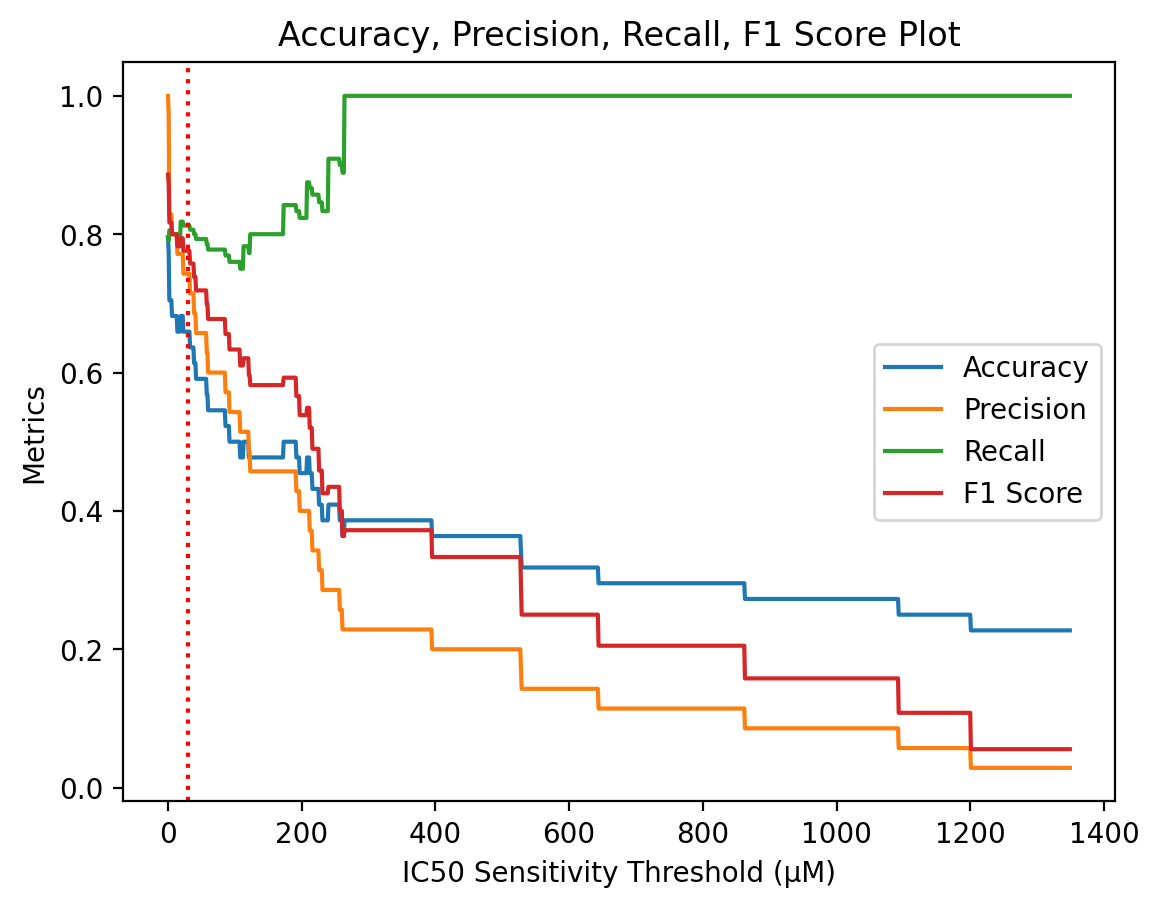

In [51]:
# グラフのサイズと解像度を設定
plt.figure(dpi=200)

# プロット
plt.plot(accs, label='Accuracy')
plt.plot(precs, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(f1s, label='F1 Score')
plt.axvline(x = 30, color = 'red', linestyle=':')

# 凡例の追加
plt.legend()

# タイトルとラベルの追加
plt.title('Accuracy, Precision, Recall, F1 Score Plot')
plt.xlabel('IC50 Sensitivity Threshold (μM)')
plt.ylabel('Metrics')

# グラフの表示
plt.show()